# Test running pretrained BERT on reddit data
- Maybe start adding multi level attention blocks at the end?

## Imports

In [1]:
try:
    import transformers
except ImportError as e:
    print('transformers not installed')
    print('Installing now...')
    !pip install -q git+https://github.com/huggingface/transformers.git
    pass

In [2]:
import reddit_bert_functions as fun

In [3]:
import numpy as np
import pandas as pd
import matplotlib
from matplotlib import pyplot as plt
from torch.utils.data import Dataset,DataLoader,TensorDataset
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,accuracy_score
import transformers
import json
from tqdm.notebook import tqdm
from transformers.utils.dummy_pt_objects import AutoModelForSequenceClassification
from transformers import AutoModelForTokenClassification,AutoConfig, AutoModel,AutoTokenizer,BertModel,BertConfig,AdamW, get_constant_schedule,BertForSequenceClassification,get_linear_schedule_with_warmup
import random
import torch
import torch.nn as nn
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

In [4]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


## Import reddit dataset, split and create PyTorch data class objects

### Test data import

In [5]:
csv_path = 'train-balanced-sarcasm.csv'
x_train, y_train, x_val, y_val, x_test, y_test = fun.split_reddit_data(csv_path)

In [ ]:
#word count per each sample
count = x_train.str.split().str.len()
plt.hist(count, bins=30, range=(0, 100))

In [ ]:
#check if even split between labels
import seaborn as sns
fig, axes = plt.subplots(1, 3, figsize=(16, 7))
fig.suptitle('Distribution of Classes Reddit\n0:Non-Sarcastic vs. 1:Sarcastic accross data splits')
sns.countplot(ax=axes[0], x=y_train)
axes[0].set_title('Training Set')
sns.countplot(ax=axes[1], x=y_val)
axes[1].set_title('Validation Set')
sns.countplot(ax=axes[2], x=y_test)
axes[2].set_title('Test Set')


### Tokenize

In [7]:
max_length = 35  #based on word count bar plot above, 35 is reasonable

tokenizer = AutoTokenizer.from_pretrained('bert-large-uncased')

reddit_train = fun.Reddit(x_train, y_train, tokenizer, max_length)
reddit_val = fun.Reddit(x_val, y_val, tokenizer, max_length)
reddit_test = fun.Reddit(x_test, y_test, tokenizer, max_length)

In [8]:
batch_size = 64
num_workers = 2
trainloader, validationloader, testloader = fun.get_data_loaders(reddit_train, reddit_val, reddit_test, batch_size, num_workers)


## Create BERT model

In [9]:
bertconfig = BertConfig()
bert_large = BertModel.from_pretrained("bert-large-uncased")

#freeze params
for param in bert_large.parameters():
    param.requires_grad = False

Some weights of the model checkpoint at bert-large-uncased were not used when initializing BertModel: ['cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [10]:
sarcasm_model = fun.bert_for_sarcasm(bert_large)
sarcasm_model.to(device)

bert_for_sarcasm(
  (input_model): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 1024, padding_idx=0)
      (position_embeddings): Embedding(512, 1024)
      (token_type_embeddings): Embedding(2, 1024)
      (LayerNorm): LayerNorm((1024,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=1024, out_features=1024, bias=True)
              (key): Linear(in_features=1024, out_features=1024, bias=True)
              (value): Linear(in_features=1024, out_features=1024, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=1024, out_features=1024, bias=True)
              (LayerNorm): LayerNorm((1024,), eps=1e-12, 

In [16]:
print(sum(p.numel() for p in sarcasm_model.parameters() if p.requires_grad))
print(sum(p.numel() for p in sarcasm_model.parameters()))

295425
335437313


## Training

In [ ]:
import time
import datetime
import math

#Training sarcasm bert
Epochs = 4

optimizer = torch.optim.AdamW(sarcasm_model.parameters(),lr = 1e-4,eps = 1e-8)
loss_function = nn.BCELoss()
model_save_dir = "/projectnb/dl523/students/nannkat/Project/training/cp.ckpt"

loss_acc = 0 
losses = []

start_time = time.time()
num_iters = math.ceil(len(reddit_train)/ batch_size)

for epoch in range(1, Epochs+1):
    
    print('Epoch: ',epoch)
    train_iter = iter(trainloader)
    sarcasm_model.train()
    train_correct = 0
    train_total = 0
    
    for idx, (encodings, labels) in enumerate(train_iter):

        labels = labels.to(device).float()
       
        inputs = encodings['input_ids']
        attention_mask = encodings['attention_mask']
       
        inputs, attention_mask = inputs.to(device), attention_mask.to(device)
        
        optimizer.zero_grad()

        output = sarcasm_model(inputs, attention_mask)
        output = torch.flatten(output)
    
        
        loss = loss_function(output,labels)
        losses.append(loss)

        loss.backward()
        optimizer.step()
        
        output[output<0.5] = 0
        output[output>=0.5] = 1
        train_correct += (output == labels).float().sum().item()
        train_total += len(labels)
        
        
        loss_acc +=loss.item()
    
        if idx%2000 == 0:
            et = time.time() - start_time
            et = str(datetime.timedelta(seconds=et))[:-7]
            log = "Elapsed [{}], Iteration [{}/{}]".format(et, idx+1, num_iters)
            log += "Loss: {:.4f}".format(loss)
            print(log)
            
    # at the end of each epoch, save model calculate validation loss + accuracy and display train accuracy vs val accuracy
    torch.save({'epoch': epoch,
            'model_state_dict': sarcasm_model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': loss}, model_save_dir)
    
    print("Model checkpoint saved to " + model_save_dir)
    
    valid_loss = 0.0
    sarcasm_model.eval()
    val_correct = 0
    val_total = 0
    print("Calculating validation accuracy....")
    for encodings, labels in validationloader:
        inputs = encodings['input_ids']
        attention_mask = encodings['attention_mask']
        
        if torch.cuda.is_available():
            labels = labels.to(device).float()
            inputs, attention_mask = inputs.to(device), attention_mask.to(device)
            
        preds = sarcasm_model(inputs, attention_mask)
        preds = torch.flatten(preds)
        loss = loss_function(preds,labels)
        
        preds[preds<0.5] = 0
        preds[preds >=0.5] = 1
        
        val_correct += (preds == labels).float().sum().item()
        val_total += len(labels)
        
    training_acc = round(train_correct/train_total,2)
    validation_acc = round(val_correct/val_total,2)
    print("Epoch {}. Training accuracy: {}. Validation accuracy: {}.".format(epoch, training_acc, validation_acc)) 

Epoch:  1
Elapsed [0:00:00], Iteration [1/12635]Loss: 0.6853
Elapsed [0:04:17], Iteration [2001/12635]Loss: 0.6814
Elapsed [0:08:35], Iteration [4001/12635]Loss: 0.7279
Elapsed [0:12:53], Iteration [6001/12635]Loss: 0.6683
Elapsed [0:17:10], Iteration [8001/12635]Loss: 0.6731
Elapsed [0:21:28], Iteration [10001/12635]Loss: 0.7472
Elapsed [0:25:46], Iteration [12001/12635]Loss: 0.6502
Model checkpoint saved to /projectnb/dl523/students/nannkat/Project/training/cp.ckpt
Calculating validation accuracy....
Epoch 1. Training accuracy: 0.61. Validation accuracy: 0.63.
Epoch:  2
Elapsed [0:30:31], Iteration [1/12635]Loss: 0.6400
Elapsed [0:34:48], Iteration [2001/12635]Loss: 0.6239
Elapsed [0:39:05], Iteration [4001/12635]Loss: 0.6872
Elapsed [0:43:23], Iteration [6001/12635]Loss: 0.6475
Elapsed [0:47:40], Iteration [8001/12635]Loss: 0.6393
Elapsed [0:51:57], Iteration [10001/12635]Loss: 0.6405
Elapsed [0:56:14], Iteration [12001/12635]Loss: 0.6459
Model checkpoint saved to /projectnb/dl523/s

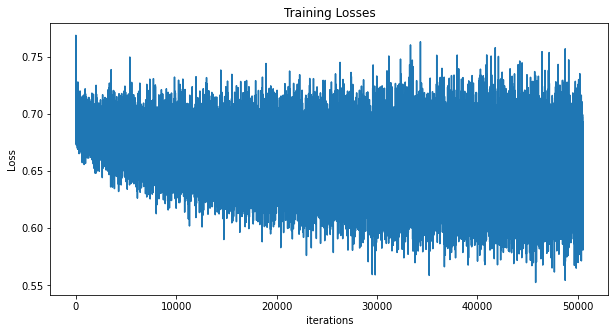

In [45]:
# Losses
plt.figure(figsize=(10,5))
plt.title("Training Losses")
plt.plot(losses)
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.show()

## Testing

In [46]:
correct = []
final_pred = []
final_lab = []
with torch.no_grad():
    
    for encodings, labels in testloader:
        inputs = encodings['input_ids']
        attention_mask = encodings['attention_mask']
        inputs, attention_mask = inputs.to(device), attention_mask.to(device)
        output = sarcasm_model(inputs,attention_mask).cpu()
        preds = output.data.max(1, keepdim=True)[1].squeeze(1).numpy()
        l = labels.cpu().numpy()
        comp = l == preds
        final_lab.extend(l)
        final_pred.extend(preds)
        for i in range(l.size):
            if comp[i] == True:
                correct.append(1)
            else:
                correct.append(0)

### Stats

In [47]:
r_words = ["Sarcastic","Not Sarcastic"]
class_report = classification_report(final_lab,final_pred,target_names =r_words)
print('\033[1m'+'Precision, Recall and Accuracy for Reddit Data:\n')
print(class_report)

Precision, Recall and Accuracy for Reddit Data:

               precision    recall  f1-score   support

    Sarcastic       0.61      0.70      0.65     50540
Not Sarcastic       0.65      0.55      0.60     50537

     accuracy                           0.63    101077
    macro avg       0.63      0.63      0.63    101077
 weighted avg       0.63      0.63      0.63    101077



### Examples?